RGB: (1228, 1840, 3) Depth_rs: (1228, 1840)
ratios FG/MG/BG: 0.4700002655431242 0.03565757328990228 0.4943421611669735


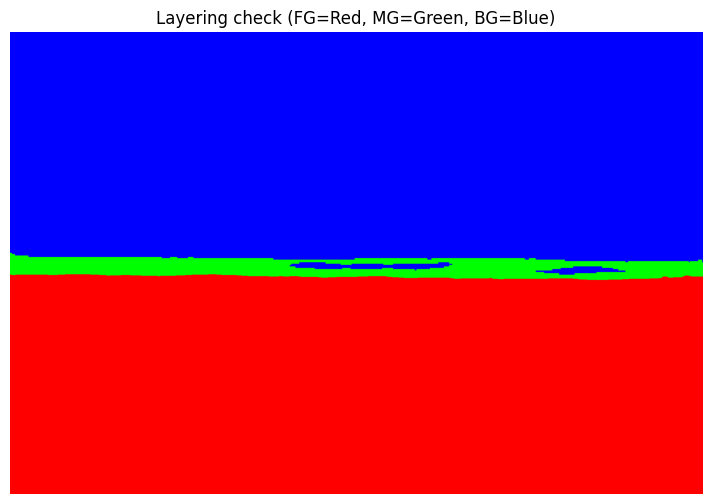

In [ ]:
#Step 1：讀檔 + 對齊尺寸 + 分層 mask（含可視化）
import os, cv2, numpy as np
import matplotlib.pyplot as plt

ROOT = "/content/9"  # 改成你的資料夾，例如 /content/6

# --- load rgb ---
rgb = cv2.imread(os.path.join(ROOT, "rgb.png"))
assert rgb is not None, f"rgb.png not found in {ROOT}"
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
H, W = rgb.shape[:2]

# --- load depth ---
depth_norm_inv = np.load(os.path.join(ROOT, "depth_norm_inv.npy")).astype(np.float32)
depth_conf = np.load(os.path.join(ROOT, "depth_conf.npy")).astype(np.float32)

# resize depth to rgb size
depth_norm_inv_rs = cv2.resize(depth_norm_inv, (W, H), interpolation=cv2.INTER_LINEAR)
depth_conf_rs     = cv2.resize(depth_conf,     (W, H), interpolation=cv2.INTER_LINEAR)

print("RGB:", rgb.shape, "Depth_rs:", depth_norm_inv_rs.shape)

# --- depth thresholds (可調) ---
t_fg = np.percentile(depth_norm_inv_rs, 53)
t_bg = np.percentile(depth_norm_inv_rs, 5)

mask_fg = depth_norm_inv_rs >= t_fg
mask_bg = depth_norm_inv_rs <= t_bg
mask_mg = (~mask_fg) & (~mask_bg)

# 你指定的修正：MG = MG ∪ FG（避免中景底下空/破圖）
mask_mg2 = mask_mg | mask_fg

print("ratios FG/MG/BG:", mask_fg.mean(), mask_mg.mean(), mask_bg.mean())

# --- visualize layering ---
vis = rgb.copy()
vis[mask_fg] = [255, 0, 0]
vis[mask_mg] = [0, 255, 0]
vis[mask_bg] = [0, 0, 255]

plt.figure(figsize=(9,6))
plt.imshow(vis)
plt.title("Layering check (FG=Red, MG=Green, BG=Blue)")
plt.axis("off")
plt.show()


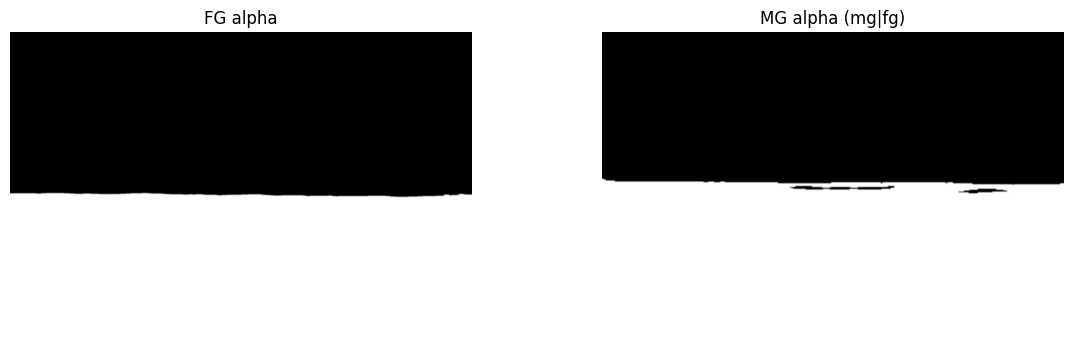

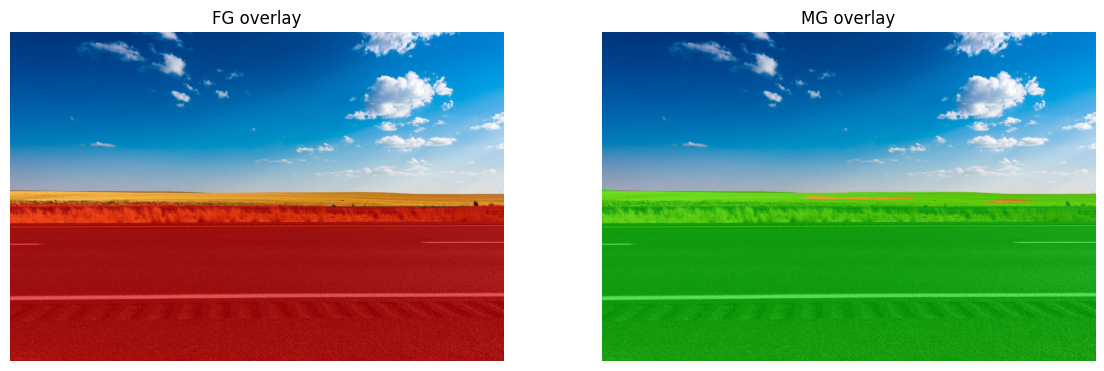

In [ ]:
#Step 2：產 RGBA（FG / MG）+ overlay 檢查
def dilate(mask, k=5):
    return cv2.dilate(mask.astype(np.uint8), np.ones((k,k), np.uint8), 1).astype(bool)

def feather(alpha, k=9):
    if k % 2 == 0: k += 1
    return cv2.GaussianBlur(alpha, (k,k), 0)

def make_rgba(img, mask, dk=5, fk=9):
    m = dilate(mask, dk)
    a = feather(m.astype(np.float32) * 255, fk)
    a = np.clip(a, 0, 255).astype(np.uint8)
    return np.dstack([img, a])

def overlay_alpha(rgb, alpha, color=(0,255,0), strength=0.55):
    out = rgb.copy().astype(np.float32)
    a = (alpha.astype(np.float32)/255.0) * strength
    for c in range(3):
        out[..., c] = out[..., c] * (1 - a) + color[c] * a
    return out.astype(np.uint8)

FG = make_rgba(rgb, mask_fg,  dk=5, fk=9)
MG = make_rgba(rgb, mask_mg2, dk=5, fk=9)   # <- 中景加前景
BG = rgb.copy()

# alpha & overlay check
plt.figure(figsize=(14,4))
plt.subplot(1,2,1); plt.imshow(FG[...,3], cmap="gray"); plt.title("FG alpha"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(MG[...,3], cmap="gray"); plt.title("MG alpha (mg|fg)"); plt.axis("off")
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,1); plt.imshow(overlay_alpha(rgb, FG[...,3], color=(255,0,0))); plt.title("FG overlay"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(overlay_alpha(rgb, MG[...,3], color=(0,255,0))); plt.title("MG overlay"); plt.axis("off")
plt.show()


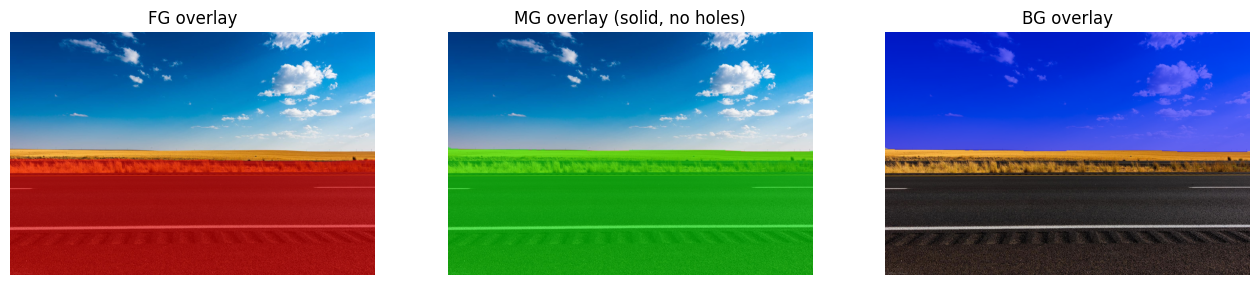

In [ ]:
# =========================================================
# Stable RGBA build (NO hole revival) — FIXED
# =========================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Utils
# -------------------------
def morph_close(mask, k=17):
    return cv2.morphologyEx(
        mask.astype(np.uint8),
        cv2.MORPH_CLOSE,
        np.ones((k, k), np.uint8)
    ).astype(bool)

def dilate(mask, k=5):
    return cv2.dilate(
        mask.astype(np.uint8),
        np.ones((k, k), np.uint8),
        1
    ).astype(bool)

def feather(alpha, k=9):
    if k % 2 == 0:
        k += 1
    return cv2.GaussianBlur(alpha, (k, k), 0)

def make_rgba(img, mask, dk=5, fk=9):
    """
    img : H×W×3 uint8
    mask: H×W bool
    """
    m = dilate(mask, dk)
    a = feather(m.astype(np.float32) * 255, fk)
    return np.dstack([img, np.clip(a, 0, 255).astype(np.uint8)])

def overlay_alpha(rgb, alpha, color=(0, 255, 0), strength=0.55):
    out = rgb.astype(np.float32).copy()
    a = (alpha.astype(np.float32) / 255.0) * strength
    for c in range(3):
        out[..., c] = out[..., c] * (1 - a) + color[c] * a
    return out.astype(np.uint8)

# =========================================================
# 1. Semantic layers (already refined!)
# =========================================================
FG_render = FG_ref if 'FG_ref' in globals() else mask_fg
MG_render = MG_ref if 'MG_ref' in globals() else mask_mg

# 保證語意互斥
MG_render = MG_render & (~FG_render)

# =========================================================
# 2. Build SUPPORT layer (MG ∪ FG, must be solid)
# =========================================================
mask_mg_support = (MG_render | FG_render)

# 🔥 關鍵步驟：union 後再做 closing，防止回洞
mask_mg_support = morph_close(mask_mg_support, k=21)


# =========================================================
# 3. Build RGBA layers
# =========================================================
FG = make_rgba(rgb, FG_render, dk=5, fk=9)
MG = make_rgba(rgb, mask_mg_support, dk=5, fk=9)
BG = rgb.copy()

# =========================================================
# 4. Visual check
# =========================================================
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.imshow(overlay_alpha(rgb, FG[..., 3], (255, 0, 0)))
plt.title("FG overlay")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlay_alpha(rgb, MG[..., 3], (0, 255, 0)))
plt.title("MG overlay (solid, no holes)")
plt.axis("off")

plt.subplot(1, 3, 3)
bg_mask = (~mask_mg_support & ~FG_render).astype(np.uint8) * 255
plt.imshow(overlay_alpha(rgb, bg_mask, (0, 0, 255)))
plt.title("BG overlay")
plt.axis("off")

plt.show()




[INFO] Mask snapped to RGB edges


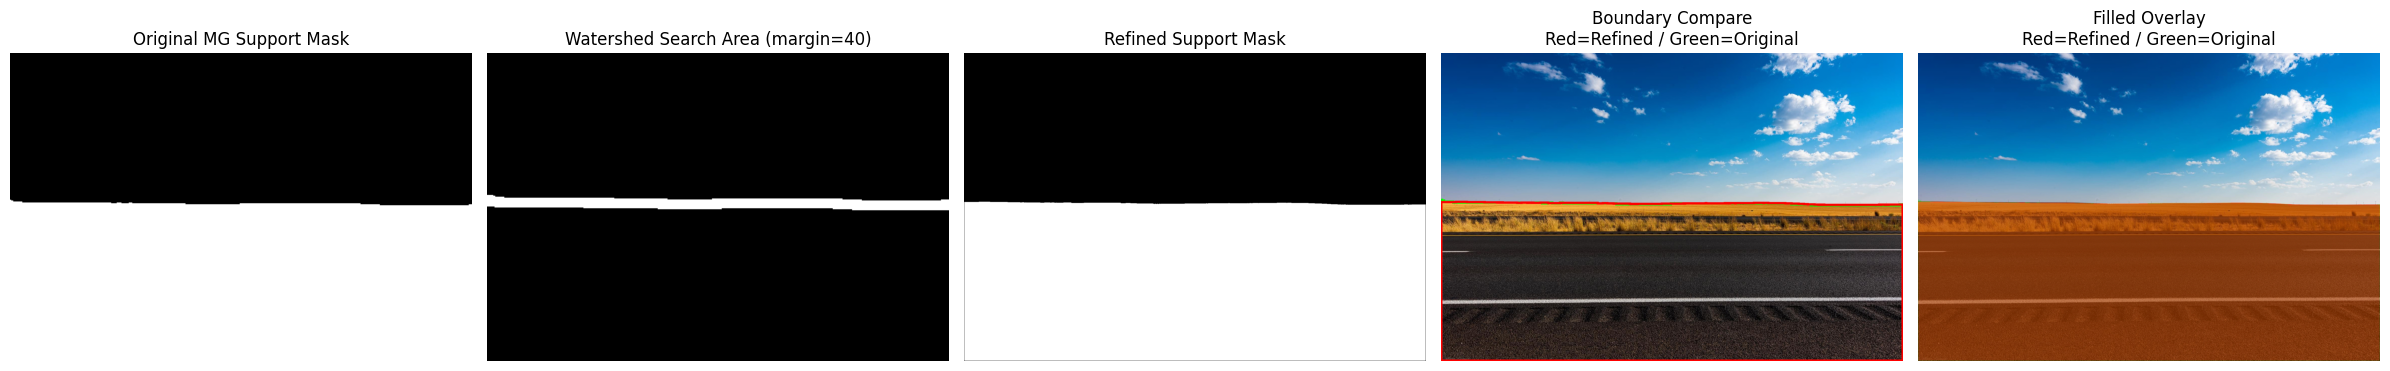

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# INPUT
# =========================================================
# rgb              : H×W×3, uint8, RGB
# mask_mg_support  : H×W, bool   (MG ∪ FG, solid support layer)

# =========================================================
# 0. Pre-processing
# =========================================================
mask_input = mask_mg_support.astype(np.uint8)
if mask_input.max() <= 1:
    mask_input *= 255

rgb_u8 = rgb.astype(np.uint8)

# =========================================================
# 1. Edge observation (for reference)
# =========================================================
gray = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 50, 150)

# =========================================================
# 2. Prepare Watershed markers
# =========================================================
snap_margin = 40
kernel = np.ones((snap_margin, snap_margin), np.uint8)

# Sure foreground (support interior)
sure_fg = cv2.erode(mask_input, kernel, iterations=1)

# Sure background (outside support)
sure_bg_area = cv2.dilate(mask_input, kernel, iterations=1)
sure_bg = cv2.bitwise_not(sure_bg_area)

# Unknown region
unknown = cv2.subtract(sure_bg_area, sure_fg)

# Markers
markers = np.zeros_like(mask_input, dtype=np.int32)
markers[sure_fg > 0] = 1
markers[sure_bg > 0] = 2
markers[unknown > 0] = 0

# =========================================================
# 3. Watershed snapping
# =========================================================
cv2.watershed(rgb_u8, markers)

# =========================================================
# 4. Refined mask (DO NOT overwrite original)
# =========================================================
mask_refined = np.zeros_like(mask_input, dtype=np.uint8)
mask_refined[markers == 1] = 255

if np.sum(mask_refined) == 0:
    print("[WARN] Watershed failed → keep original support mask")
    mask_mg_refined = mask_mg_support.copy()
else:
    print("[INFO] Mask snapped to RGB edges")
    mask_mg_refined = mask_refined > 0   # bool

# =========================================================
# 5. Boundary overlay (debug)
# =========================================================
vis_kernel = np.ones((3, 3), np.uint8)

ref_erode = cv2.erode(mask_refined, vis_kernel, iterations=1)
ref_boundary = (mask_refined > 0) ^ (ref_erode > 0)

orig_erode = cv2.erode(mask_input, vis_kernel, iterations=1)
orig_boundary = (mask_input > 0) ^ (orig_erode > 0)

# -------------------------
# Thicken boundaries
# -------------------------
thick_kernel = np.ones((5, 5), np.uint8)

ref_boundary_thick = cv2.dilate(
    ref_boundary.astype(np.uint8),
    thick_kernel,
    iterations=2
) > 0

orig_boundary_thick = cv2.dilate(
    orig_boundary.astype(np.uint8),
    thick_kernel,
    iterations=2
) > 0

# -------------------------
# Overlay boundaries
# -------------------------
overlay_boundary = rgb_u8.copy()
overlay_boundary[orig_boundary_thick] = [0, 255, 0]   # green = original
overlay_boundary[ref_boundary_thick]  = [255, 0, 0]   # red   = refined

# =========================================================
# 6. Filled overlay (IMPORTANT PART)
# =========================================================
overlay_filled = rgb_u8.copy().astype(np.float32)

alpha_refined  = 0.45
alpha_original = 0.30

orig_mask_bool = mask_input > 0
ref_mask_bool  = mask_refined > 0

# Original support → green
overlay_filled[orig_mask_bool] = (
    (1 - alpha_original) * overlay_filled[orig_mask_bool]
    + alpha_original * np.array([0, 255, 0])
)

# Refined support → red
overlay_filled[ref_mask_bool] = (
    (1 - alpha_refined) * overlay_filled[ref_mask_bool]
    + alpha_refined * np.array([255, 0, 0])
)

overlay_filled = overlay_filled.astype(np.uint8)

# =========================================================
# 7. Visualization
# =========================================================
plt.figure(figsize=(24, 5))

plt.subplot(1, 5, 1)
plt.imshow(mask_input, cmap="gray")
plt.title("Original MG Support Mask")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(unknown, cmap="gray")
plt.title(f"Watershed Search Area (margin={snap_margin})")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(mask_refined, cmap="gray")
plt.title("Refined Support Mask")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(overlay_boundary)
plt.title("Boundary Compare\nRed=Refined / Green=Original")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(overlay_filled)
plt.title("Filled Overlay\nRed=Refined / Green=Original")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#Step 3：做「單一 tile」鏡像無縫（A|mirror(A)）函式
def make_seamless_mirror_loop(layer, blend_w=64):
    """
    layer: H x W x C (RGB or RGBA)
    return: H x (2W) x C  (單一 tile: A|B)
    """
    H, W = layer.shape[:2]
    mirror = layer[:, ::-1].copy()

    right  = layer[:, W-blend_w:W]
    left_m = mirror[:, :blend_w]

    alpha = np.linspace(0, 1, blend_w, dtype=np.float32)[None, :, None]
    seam = (1 - alpha) * right.astype(np.float32) + alpha * left_m.astype(np.float32)
    seam = seam.astype(layer.dtype)

    loop_layer = np.concatenate([layer[:, :W-blend_w], seam, mirror[:, blend_w:]], axis=1)
    return loop_layer


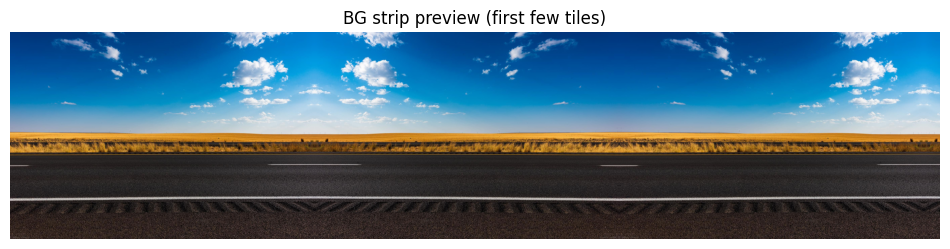

In [ ]:
#Step 4：做「長條世界」ABABAB…（避免跑完跳回起點）

#你指定要：原圖→鏡像→原圖→鏡像反覆，所以必做這個。

def make_tiled_mirror_strip(layer, blend_w=64, repeat=6):
    """
    layer -> base tile (A|B) -> repeat to long strip: ABABAB...
    """
    base = make_seamless_mirror_loop(layer, blend_w=blend_w)  # width = 2W
    strip = np.concatenate([base for _ in range(repeat)], axis=1)
    return strip

BLEND_W = 64
REPEAT  = 6  # 越大越不會看到「回到起點」

BG_strip = make_tiled_mirror_strip(BG, blend_w=BLEND_W, repeat=REPEAT)
MG_strip = make_tiled_mirror_strip(MG, blend_w=BLEND_W, repeat=REPEAT)
FG_strip = make_tiled_mirror_strip(FG, blend_w=BLEND_W, repeat=REPEAT)

plt.figure(figsize=(12,4))
plt.imshow(BG_strip[:, :min(BG_strip.shape[1], 3*W)])  # 只顯示前面一段
plt.title("BG strip preview (first few tiles)")
plt.axis("off")
plt.show()

In [ ]:
#Step 5：FAST PREVIEW 輸出影片（三層全部 loop 的平面捲軸）
def scroll_crop(layer, offset_x, out_w):
    W_big = layer.shape[1]
    x = offset_x % (W_big - out_w)
    return layer[:, x:x+out_w]

def alpha_comp(bg, fg):
    out = bg.astype(np.float32)
    a = fg[..., 3:4] / 255.0
    out[..., :3] = fg[..., :3] * a + out[..., :3] * (1 - a)
    return out.astype(np.uint8)

# ---- preview config ----
SCALE_PREVIEW = 1.0
N = 300
fps = 30

speed_bg = 0.6
speed_mg = 2.4
speed_fg = 4.0

# resize strips
BG_p = cv2.resize(BG_strip, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
MG_p = cv2.resize(MG_strip, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
FG_p = cv2.resize(FG_strip, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
Hp, Wp = int(H*SCALE_PREVIEW), int(W*SCALE_PREVIEW)

OUTPUT_MP4 = "parallax_side_scroll_preview_tiled_long.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_MP4, fourcc, fps, (Wp, Hp))

for i in range(N):
    t = i / (N - 1)
    t = t * t * (3 - 2 * t)  # smoothstep

    bg_x = int(t * speed_bg * Wp)
    mg_x = int(t * speed_mg * Wp)
    fg_x = int(t * speed_fg * Wp)

    bg_frame = scroll_crop(BG_p, bg_x, Wp)
    mg_frame = scroll_crop(MG_p, mg_x, Wp)
    fg_frame = scroll_crop(FG_p, fg_x, Wp)

    frame = bg_frame.copy()
    frame = alpha_comp(frame, mg_frame)
    frame = alpha_comp(frame, fg_frame)

    writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

writer.release()
print(f"[✓] Saved: {OUTPUT_MP4}")

In [ ]:
# ==========================================
# Step 5 (改)：視覺詐欺版 - 極速路感 + 懸吊震動
# ==========================================

# 1. 額外函式：製造「速度感噪點」(給路面增加紋理，不然太乾淨看不出移動)
def add_speed_noise(img_strip, intensity=0.15):
    """
    在圖片上疊加高斯噪點，讓平滑的柏油路有「顆粒」可以流動
    """
    h, w, c = img_strip.shape
    noise = np.random.randn(h, w, c) * 255 * intensity
    noisy_img = img_strip.astype(np.float32) + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# 2. 針對前景 FG 做特殊處理：增加噪點
print("正在為前景鋪設『柏油顆粒』以增強速度感...")
FG_strip_noisy = add_speed_noise(FG_strip, intensity=0.08) # 強度可調 0.05~0.15

# ---- Preview Config (Turbo Mode) ----
SCALE_PREVIEW = 1.0  # 若跑不動可改 0.5
N = 300              # 總幀數
fps = 30             # 為了流暢感，建議 60fps

# 速度設定：拉大差距
speed_bg = 0.5   # 雲：幾乎不動
speed_mg = 3.0   # 草：中速
speed_fg = 36.0  # 路：極速 (原本是 4.0，現在拉到 18.0)

# 為了讓震動不露出黑邊，我們裁切掉周圍一圈
pad = 20
Hp, Wp = int(H*SCALE_PREVIEW), int(W*SCALE_PREVIEW)
out_h, out_w = Hp - 2*pad, Wp - 2*pad

# resize strips
BG_p = cv2.resize(BG_strip, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
MG_p = cv2.resize(MG_strip, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
FG_p = cv2.resize(FG_strip_noisy, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW) # 用有噪點的版

OUTPUT_MP4 = "parallax_turbo_shake.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_MP4, fourcc, fps, (out_w, out_h))

print("開始渲染 Turbo 影片...")

for i in range(N):
    # 時間 t
    t_linear = i

    # 1. 計算位移 (Scroll)
    bg_x = int(t_linear * speed_bg)
    mg_x = int(t_linear * speed_mg)
    fg_x = int(t_linear * speed_fg) # 極速

    # 2. 視覺詐欺核心：懸吊震動 (Camera Shake)
    # 模擬引擎的高頻震動 + 路面起伏的低頻震動
    shake_y = int(2.5 * np.sin(i * 0.5) + 1.5 * np.cos(i * 1.2))
    shake_x = int(1.0 * np.sin(i * 0.8))

    # 3. 裁切圖層
    bg_frame = scroll_crop(BG_p, bg_x, Wp)
    mg_frame = scroll_crop(MG_p, mg_x, Wp)
    fg_frame = scroll_crop(FG_p, fg_x, Wp)

    # 4. 合成
    frame = bg_frame.copy()
    frame = alpha_comp(frame, mg_frame)
    frame = alpha_comp(frame, fg_frame)

    # 5. 應用震動並裁切中心 (避免黑邊)
    # 邏輯：從 (pad + shake) 的位置切出 (out_h, out_w)
    y_start = pad + shake_y
    x_start = pad + shake_x
    final_frame = frame[y_start:y_start+out_h, x_start:x_start+out_w]

    writer.write(cv2.cvtColor(final_frame, cv2.COLOR_RGB2BGR))

writer.release()
print(f"[✓] 視覺詐欺完成！影片已存為: {OUTPUT_MP4}")

In [ ]:
# ==========================================
# Step 5 (最終版)：極速動態模糊 + 平滑隨機光影 + 懸吊震動
# ==========================================

# 1. 移除原本的噪點函式，改用「水平動態模糊」
def apply_motion_blur(img_strip, kernel_size=31):
    """
    對圖片施加強烈的「水平方向」模糊，模擬相機快門跟不上車速的感覺。
    kernel_size 越大，速度感越強 (必須是奇數)。
    """
    return cv2.GaussianBlur(img_strip, (kernel_size, 1), 0)

# 2. 針對前景 FG 做「動態模糊」處理
print("正在為前景應用『動態模糊』(Motion Blur)...")
FG_strip_blurred = apply_motion_blur(FG_strip, kernel_size=51) # 數值越大越模糊，速度感越強

# ---- Preview Config (Turbo Mode) ----
SCALE_PREVIEW = 1.0
N = 300
fps = 30

# 速度設定
speed_bg = 1.5   # 雲：幾乎不動
speed_mg = 9.0   # 草：中速
speed_fg = 180.0  # 路：極速 (只有模糊後才能跑這麼快還不穿幫)

pad = 20
Hp, Wp = int(H*SCALE_PREVIEW), int(W*SCALE_PREVIEW)
out_h, out_w = Hp - 2*pad, Wp - 2*pad

# resize strips (注意：FG 用 blurred 版)
BG_p = cv2.resize(BG_strip, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
MG_p = cv2.resize(MG_strip, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
FG_p = cv2.resize(FG_strip_blurred, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)

OUTPUT_MP4 = "parallax_motion_shadow_smooth.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_MP4, fourcc, fps, (out_w, out_h))

# ==========================================
# [關鍵修改] 預先生成「平滑隨機光影表」
# ==========================================
print("正在生成隨機環境光影...")

# 控制點數量：決定光影變化的頻率
# 8 個點表示在 300 幀內只變化 8 次亮度，非常平緩自然
num_control_points = 10

# 隨機亮度範圍：0.6 (樹蔭下) ~ 1.05 (陽光直射)
random_values = np.random.uniform(0.8, 1.05, size=(1, num_control_points)).astype(np.float32)

# 利用 Cubic 插值將 8 個點拉長成 300 幀 (N)，形成平滑波浪
light_curve = cv2.resize(random_values, (N, 1), interpolation=cv2.INTER_CUBIC).flatten()
# 限制範圍避免過曝或全黑
light_curve = np.clip(light_curve, 0.5, 1.1)

print("開始渲染 (含平滑光影特效)...")

for i in range(N):
    t_linear = i

    # 1. 計算位移
    bg_x = int(t_linear * speed_bg)
    mg_x = int(t_linear * speed_mg)
    fg_x = int(t_linear * speed_fg)

    # 2. 懸吊震動 (Camera Shake)
    shake_y = int(2.5 * np.sin(i * 0.5) + 1.5 * np.cos(i * 1.2))
    shake_x = int(1.0 * np.sin(i * 0.8))

    # 3. 裁切圖層
    bg_frame = scroll_crop(BG_p, bg_x, Wp)
    mg_frame = scroll_crop(MG_p, mg_x, Wp)
    fg_frame = scroll_crop(FG_p, fg_x, Wp)

    # 4. 合成
    frame = bg_frame.copy()
    frame = alpha_comp(frame, mg_frame)
    frame = alpha_comp(frame, fg_frame)

    # 5. [修改] 應用預先算好的平滑光影
    shadow_intensity = light_curve[i]

    # 使用 convertScaleAbs 調整亮度 (alpha=對比度/亮度增益)
    frame = cv2.convertScaleAbs(frame, alpha=shadow_intensity, beta=0)

    # 6. 應用震動並裁切 (避免黑邊)
    y_start = pad + shake_y
    x_start = pad + shake_x
    final_frame = frame[y_start:y_start+out_h, x_start:x_start+out_w]

    writer.write(cv2.cvtColor(final_frame, cv2.COLOR_RGB2BGR))

writer.release()
print(f"[✓] 渲染完成！影片已存為: {OUTPUT_MP4}")

In [ ]:
# =========================================================
# Stable RGBA build (NO hole revival) + SAVE overlays
# =========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
ROOT = "/content/9"   # 依你的環境
OUT_DIR = os.path.join(ROOT, "overlay_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# Utils
# =========================
def morph_close(mask, k=17):
    return cv2.morphologyEx(
        mask.astype(np.uint8),
        cv2.MORPH_CLOSE,
        np.ones((k, k), np.uint8)
    ).astype(bool)

def dilate(mask, k=5):
    return cv2.dilate(
        mask.astype(np.uint8),
        np.ones((k, k), np.uint8),
        1
    ).astype(bool)

def feather(alpha, k=9):
    if k % 2 == 0:
        k += 1
    return cv2.GaussianBlur(alpha, (k, k), 0)

def make_rgba(img, mask, dk=5, fk=9):
    m = dilate(mask, dk)
    a = feather(m.astype(np.float32) * 255, fk)
    return np.dstack([img, np.clip(a, 0, 255).astype(np.uint8)])

def overlay_alpha(rgb, alpha, color=(0,255,0), strength=0.55):
    out = rgb.astype(np.float32).copy()
    a = (alpha.astype(np.float32) / 255.0) * strength
    for c in range(3):
        out[..., c] = out[..., c] * (1 - a) + color[c] * a
    return out.astype(np.uint8)

# =========================================================
# Stable RGBA build + SAVE overlays
# MG overlay = MG ∪ FG (as requested)
# =========================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
ROOT = "/content/9"
OUT_DIR = os.path.join(ROOT, "overlay_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# Utils
# =========================
def morph_close(mask, k=17):
    return cv2.morphologyEx(
        mask.astype(np.uint8),
        cv2.MORPH_CLOSE,
        np.ones((k, k), np.uint8)
    ).astype(bool)

def dilate(mask, k=5):
    return cv2.dilate(
        mask.astype(np.uint8),
        np.ones((k, k), np.uint8),
        1
    ).astype(bool)

def feather(alpha, k=9):
    if k % 2 == 0:
        k += 1
    return cv2.GaussianBlur(alpha, (k, k), 0)

def make_rgba(img, mask, dk=5, fk=9):
    m = dilate(mask, dk)
    a = feather(m.astype(np.float32) * 255, fk)
    return np.dstack([img, np.clip(a, 0, 255).astype(np.uint8)])

def overlay_alpha(rgb, alpha, color=(0,255,0), strength=0.55):
    out = rgb.astype(np.float32).copy()
    a = (alpha.astype(np.float32) / 255.0) * strength
    for c in range(3):
        out[..., c] = out[..., c] * (1 - a) + color[c] * a
    return out.astype(np.uint8)

# =========================
# Load RGB
# =========================
rgb = cv2.imread(os.path.join(ROOT, "rgb.png"))
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

# 假設以下 mask 已在前面算好
# mask_fg, mask_mg
# FG_ref / MG_ref 若存在也會自動用

# =========================
# 1. Semantic layers (語意互斥，用於結構)
# =========================
FG_render = FG_ref if 'FG_ref' in globals() else mask_fg
MG_render = MG_ref if 'MG_ref' in globals() else mask_mg

# 語意互斥（給 pipeline 用）
MG_render = MG_render & (~FG_render)

# =========================
# 2. Semantic MG (穩定、補洞)
# =========================
mask_mg_semantic = (MG_render | FG_render)
mask_mg_semantic = morph_close(mask_mg_semantic, k=21)
mask_mg_semantic = mask_mg_semantic & (~FG_render)  # 保持語意互斥

# =========================
# 3. VISUAL MG = MG ∪ FG（你指定要的）
# =========================
mask_mg_union = mask_mg_semantic | FG_render

# =========================
# 4. Build overlays
# =========================
FG_overlay = overlay_alpha(
    rgb,
    FG_render.astype(np.uint8) * 255,
    color=(255, 0, 0)
)

MG_overlay = overlay_alpha(
    rgb,
    mask_mg_union.astype(np.uint8) * 255,   # 🔥 MG ∪ FG
    color=(0, 255, 0)
)

BG_overlay = overlay_alpha(
    rgb,
    (~mask_mg_union & ~FG_render).astype(np.uint8) * 255,
    color=(0, 0, 255)
)

# =========================
# 5. Save (NO text, NO border, lossless)
# =========================
cv2.imwrite(
    os.path.join(OUT_DIR, "FG_overlay.png"),
    cv2.cvtColor(FG_overlay, cv2.COLOR_RGB2BGR)
)

cv2.imwrite(
    os.path.join(OUT_DIR, "MG_overlay_union.png"),
    cv2.cvtColor(MG_overlay, cv2.COLOR_RGB2BGR)
)

cv2.imwrite(
    os.path.join(OUT_DIR, "BG_overlay.png"),
    cv2.cvtColor(BG_overlay, cv2.COLOR_RGB2BGR)
)

print("[✓] Saved overlays (MG = MG ∪ FG) to:")
print(OUT_DIR)

# =========================
# (Optional) On-screen preview
# =========================
plt.figure(figsize=(16,5))
plt.subplot(1,3,1); plt.imshow(FG_overlay); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(MG_overlay); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(BG_overlay); plt.axis("off")
plt.show()



In [ ]:
def make_no_mirror_strip(layer, repeat=6):
    """
    不 mirror 的 tiled strip: A | A | A | ...
    layer: H×W×C (RGB or RGBA)
    """
    tile = np.concatenate([layer, layer], axis=1)  # A | A
    strip = np.concatenate([tile] * repeat, axis=1)
    return strip

# === 建立不 mirror strips（A|A）===
BG_strip_nomirror = make_no_mirror_strip(BG, repeat=6)
MG_strip_nomirror = make_no_mirror_strip(MG, repeat=6)
FG_strip_nomirror = make_no_mirror_strip(FG, repeat=6)
# Step 5：FAST PREVIEW（❌ no-mirror version）

def scroll_crop(layer, offset_x, out_w):
    W_big = layer.shape[1]
    x = offset_x % (W_big - out_w)
    return layer[:, x:x+out_w]

def alpha_comp(bg, fg):
    out = bg.astype(np.float32)
    a = fg[..., 3:4] / 255.0
    out[..., :3] = fg[..., :3] * a + out[..., :3] * (1 - a)
    return out.astype(np.uint8)

# ---- preview config ----
SCALE_PREVIEW = 1.0
N = 300
fps = 30

speed_bg = 0.6
speed_mg = 2.4
speed_fg = 4.0

# resize strips  ❌ 使用「不 mirror strip」
BG_p = cv2.resize(BG_strip_nomirror, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
MG_p = cv2.resize(MG_strip_nomirror, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)
FG_p = cv2.resize(FG_strip_nomirror, None, fx=SCALE_PREVIEW, fy=SCALE_PREVIEW)

Hp, Wp = int(H * SCALE_PREVIEW), int(W * SCALE_PREVIEW)

OUTPUT_MP4 = "parallax_side_scroll_preview_NO_MIRROR.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUTPUT_MP4, fourcc, fps, (Wp, Hp))

for i in range(N):
    t = i / (N - 1)
    t = t * t * (3 - 2 * t)  # smoothstep

    bg_x = int(t * speed_bg * Wp)
    mg_x = int(t * speed_mg * Wp)
    fg_x = int(t * speed_fg * Wp)

    bg_frame = scroll_crop(BG_p, bg_x, Wp)
    mg_frame = scroll_crop(MG_p, mg_x, Wp)
    fg_frame = scroll_crop(FG_p, fg_x, Wp)

    frame = bg_frame.copy()
    frame = alpha_comp(frame, mg_frame)
    frame = alpha_comp(frame, fg_frame)

    writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

writer.release()
print(f"[✓] Saved: {OUTPUT_MP4}")


[✓] Saved: parallax_side_scroll_preview_NO_MIRROR.mp4
